<a href="https://colab.research.google.com/github/kovarshini/ghk2/blob/main/KPI_drift_and_bias_in_manufacturing_AI_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Cell 1: Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML and Statistical Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [46]:
# Cell 2: Define the main monitoring class
class ManufacturingKPIMonitor:
    def __init__(self):
        self.reference_data = None
        self.current_model = None
        self.scaler = StandardScaler()
        self.drift_detectors = {}
        self.kpi_thresholds = {
            'production_rate': {'warning': 0.05, 'critical': 0.1},
            'defect_rate': {'warning': 0.02, 'critical': 0.05},
            'equipment_efficiency': {'warning': 0.03, 'critical': 0.08}
        }

In [47]:
# Cell 3: Fixed data generation method
def generate_synthetic_manufacturing_data(self, n_samples=10000):
    """Generate synthetic manufacturing data simulating Hitachi's use case"""
    np.random.seed(42)

    # Time range - ensure we generate exactly n_samples dates
    dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='H')

    # Manufacturing features - all with exactly n_samples elements
    data = {
        'timestamp': dates,
        'temperature': np.random.normal(75, 5, n_samples),
        'pressure': np.random.normal(100, 10, n_samples),
        'vibration': np.random.normal(2.5, 0.5, n_samples),
        'humidity': np.random.normal(45, 8, n_samples),
        'machine_speed': np.random.normal(1500, 100, n_samples),
        'material_quality': np.random.choice(['A', 'B', 'C'], n_samples, p=[0.7, 0.2, 0.1]),
        'operator_shift': np.random.choice(['Morning', 'Evening', 'Night'], n_samples),
        'equipment_age_days': np.random.randint(1, 365*3, n_samples),
        'maintenance_count': np.random.poisson(5, n_samples),
    }

    df = pd.DataFrame(data)

    # Simulate KPI relationships with some drift over time
    time_factor = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / (86400 * 180)

    # Production Rate KPI
    df['production_rate'] = (
        100 +
        10 * np.sin(time_factor * 2 * np.pi) +  # Seasonal pattern
        5 * (df['temperature'] - 75) / 5 +
        3 * (df['machine_speed'] - 1500) / 100 -
        2 * (df['equipment_age_days'] / 365) +
        np.random.normal(0, 2, n_samples)
    )

    # Defect Rate KPI (introduce bias and drift)
    defect_bias = np.where(df['operator_shift'] == 'Night', 0.5, 0)
    defect_drift = 0.1 * time_factor  # Increasing drift over time

    df['defect_rate'] = (
        2.0 +
        defect_drift +
        defect_bias +
        0.5 * (df['vibration'] - 2.5) / 0.5 +
        0.3 * (df['pressure'] - 100) / 10 +
        np.random.exponential(0.5, n_samples)
    )

    # Equipment Efficiency KPI
    df['equipment_efficiency'] = (
        85 +
        5 * np.cos(time_factor * 4 * np.pi) +
        2 * (df['maintenance_count'] / 10) -
        3 * (df['equipment_age_days'] / 365) +
        np.random.normal(0, 3, n_samples)
    )

    # Add some categorical bias
    df['quality_rating'] = np.where(
        (df['material_quality'] == 'C') & (df['operator_shift'] == 'Night'),
        'Low',
        np.where(df['material_quality'] == 'A', 'High', 'Medium')
    )

    return df

# Add the fixed method to the class
ManufacturingKPIMonitor.generate_synthetic_manufacturing_data = generate_synthetic_manufacturing_data

In [48]:
# Cell 4: Add drift detection setup method
def setup_drift_detection(self, reference_data, features):
    """Initialize drift detectors for specified features"""
    for feature in features:
        # Using Kolmogorov-Smirnov test for drift detection
        ref_data = reference_data[feature].values
        self.drift_detectors[feature] = {
            'reference_data': ref_data,
            'reference_mean': ref_data.mean(),
            'reference_std': ref_data.std()
        }

ManufacturingKPIMonitor.setup_drift_detection = setup_drift_detection

In [49]:
# Cell 5: Add feature drift detection method
def detect_feature_drift(self, current_data, features):
    """Detect drift in manufacturing features using statistical tests"""
    drift_results = {}

    for feature in features:
        if feature in self.drift_detectors:
            ref_data = self.drift_detectors[feature]['reference_data']
            curr_data = current_data[feature].values

            # Kolmogorov-Smirnov test
            ks_stat, p_value = ks_2samp(ref_data, curr_data)

            # Calculate drift magnitude
            ref_mean = self.drift_detectors[feature]['reference_mean']
            curr_mean = curr_data.mean()
            drift_magnitude = abs(curr_mean - ref_mean) / ref_mean if ref_mean != 0 else 0

            drift_results[feature] = {
                'drift_detected': p_value < 0.05,
                'p_value': p_value,
                'ks_statistic': ks_stat,
                'drift_magnitude': drift_magnitude,
                'reference_mean': ref_mean,
                'current_mean': curr_mean
            }

    return drift_results

ManufacturingKPIMonitor.detect_feature_drift = detect_feature_drift

In [50]:
# Cell 6: Add KPI drift analysis method
def analyze_kpi_drift(self, reference_kpis, current_kpis):
    """Analyze drift in key performance indicators"""
    kpi_drift_results = {}

    for kpi in ['production_rate', 'defect_rate', 'equipment_efficiency']:
        if kpi in reference_kpis.columns and kpi in current_kpis.columns:
            # Statistical test for drift
            ks_stat, p_value = ks_2samp(reference_kpis[kpi], current_kpis[kpi])

            # Calculate drift magnitude
            ref_mean = reference_kpis[kpi].mean()
            curr_mean = current_kpis[kpi].mean()
            drift_magnitude = abs(curr_mean - ref_mean) / ref_mean if ref_mean != 0 else 0

            # Determine drift severity
            thresholds = self.kpi_thresholds.get(kpi, {'warning': 0.05, 'critical': 0.1})

            if drift_magnitude >= thresholds['critical']:
                severity = 'CRITICAL'
            elif drift_magnitude >= thresholds['warning']:
                severity = 'WARNING'
            else:
                severity = 'NORMAL'

            kpi_drift_results[kpi] = {
                'ks_statistic': ks_stat,
                'p_value': p_value,
                'drift_magnitude': drift_magnitude,
                'reference_mean': ref_mean,
                'current_mean': curr_mean,
                'severity': severity
            }

    return kpi_drift_results

ManufacturingKPIMonitor.analyze_kpi_drift = analyze_kpi_drift

In [51]:
# Cell 7: Add bias analysis method
def analyze_bias(self, data, protected_attributes, target_kpi):
    """Analyze bias in manufacturing KPIs"""
    bias_results = {}

    for attribute in protected_attributes:
        if attribute in data.columns:
            # Group by protected attribute
            groups = data.groupby(attribute)[target_kpi]

            # Statistical significance test
            group_values = [group[1].values for group in groups]
            if len(group_values) >= 2:
                f_stat, p_value = stats.f_oneway(*group_values)

                # Calculate bias magnitude
                group_means = groups.mean()
                max_bias = (group_means.max() - group_means.min()) / group_means.mean()

                bias_results[attribute] = {
                    'f_statistic': f_stat,
                    'p_value': p_value,
                    'group_means': group_means.to_dict(),
                    'max_bias': max_bias,
                    'is_biased': p_value < 0.05
                }

    return bias_results

ManufacturingKPIMonitor.analyze_bias = analyze_bias

In [52]:
# Cell 8: Add predictive model training method
def train_predictive_model(self, features, target):
    """Train a predictive model for KPI forecasting"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=42
    )

    # Scale features
    X_train_scaled = self.scaler.fit_transform(X_train)
    X_test_scaled = self.scaler.transform(X_test)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    self.current_model = model

    return {
        'model': model,
        'mae': mae,
        'r2': r2,
        'feature_importance': dict(zip(features.columns, model.feature_importances_))
    }

ManufacturingKPIMonitor.train_predictive_model = train_predictive_model

In [53]:
# Cell 9: Add dashboard generation method
def generate_dashboard(self, drift_results, bias_results, model_results):
    """Generate comprehensive monitoring dashboard"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Hitachi Manufacturing AI: KPI Drift and Bias Analysis Dashboard',
                fontsize=16, fontweight='bold')

    # 1. KPI Drift Visualization
    kpis = list(drift_results.keys())
    drift_magnitudes = [drift_results[kpi]['drift_magnitude'] for kpi in kpis]
    severities = [drift_results[kpi]['severity'] for kpi in kpis]

    colors = ['green' if s == 'NORMAL' else 'orange' if s == 'WARNING' else 'red'
             for s in severities]

    axes[0, 0].bar(kpis, drift_magnitudes, color=colors, alpha=0.7)
    axes[0, 0].set_title('KPI Drift Analysis')
    axes[0, 0].set_ylabel('Drift Magnitude')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Add threshold lines
    for kpi in kpis:
        threshold = self.kpi_thresholds.get(kpi, {'warning': 0.05})['warning']
        axes[0, 0].axhline(y=threshold, color='orange', linestyle='--', alpha=0.7, label='Warning Threshold' if kpi == kpis[0] else "")

    # 2. Bias Analysis
    if bias_results:
        bias_attributes = list(bias_results.keys())
        bias_magnitudes = [bias_results[attr]['max_bias'] for attr in bias_attributes]
        is_biased = [bias_results[attr]['is_biased'] for attr in bias_attributes]

        colors = ['red' if biased else 'green' for biased in is_biased]
        axes[0, 1].bar(bias_attributes, bias_magnitudes, color=colors, alpha=0.7)
        axes[0, 1].set_title('Bias Analysis by Protected Attribute')
        axes[0, 1].set_ylabel('Bias Magnitude')
        axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Feature Importance
    if model_results and 'feature_importance' in model_results:
        feature_importance = model_results['feature_importance']
        features = list(feature_importance.keys())[:10]  # Top 10 features
        importance = list(feature_importance.values())[:10]

        axes[1, 0].barh(features, importance, alpha=0.7)
        axes[1, 0].set_title('Top 10 Feature Importances')
        axes[1, 0].set_xlabel('Importance Score')

    # 4. Model Performance
    if model_results:
        metrics = ['MAE', 'R²']
        values = [model_results.get('mae', 0), model_results.get('r2', 0)]

        axes[1, 1].bar(metrics, values, alpha=0.7, color=['blue', 'green'])
        axes[1, 1].set_title('Model Performance Metrics')
        axes[1, 1].set_ylabel('Score')
        for i, v in enumerate(values):
            axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

ManufacturingKPIMonitor.generate_dashboard = generate_dashboard

In [54]:
# Cell 10: Add alert report generation method
def generate_alert_report(self, drift_results, bias_results):
    """Generate alert report for critical issues"""
    critical_alerts = []
    warning_alerts = []

    # Check for critical KPI drift
    for kpi, result in drift_results.items():
        if result['severity'] == 'CRITICAL':
            critical_alerts.append(
                f"CRITICAL: {kpi} shows significant drift "
                f"(magnitude: {result['drift_magnitude']:.3f})"
            )
        elif result['severity'] == 'WARNING':
            warning_alerts.append(
                f"WARNING: {kpi} shows warning-level drift "
                f"(magnitude: {result['drift_magnitude']:.3f})"
            )

    # Check for bias
    for attribute, result in bias_results.items():
        if result['is_biased']:
            critical_alerts.append(
                f"BIAS DETECTED: Significant bias found in {attribute} "
                f"(p-value: {result['p_value']:.6f})"
            )

    # Print alerts
    if critical_alerts or warning_alerts:
        print("MANUFACTURING AI ALERT REPORT")
        print("=" * 50)

        if critical_alerts:
            print("\nCRITICAL ALERTS:")
            for alert in critical_alerts:
                print(f"   • {alert}")

        if warning_alerts:
            print("\nWARNING ALERTS:")
            for alert in warning_alerts:
                print(f"   • {alert}")
    else:
        print("All systems normal - No critical alerts")

ManufacturingKPIMonitor.generate_alert_report = generate_alert_report

In [55]:
# Cell 11: Initialize and generate data
print("Hitachi Manufacturing AI: KPI Drift and Bias Analysis")
print("=" * 60)

# Initialize monitoring system
monitor = ManufacturingKPIMonitor()

# Generate synthetic manufacturing data
print("Generating manufacturing dataset...")
manufacturing_data = monitor.generate_synthetic_manufacturing_data(10000)

# Display dataset info
print(f"Dataset shape: {manufacturing_data.shape}")
print("\nDataset columns:")
print(manufacturing_data.columns.tolist())
print("\nFirst few rows:")
display(manufacturing_data.head())

Hitachi Manufacturing AI: KPI Drift and Bias Analysis
Generating manufacturing dataset...
Dataset shape: (10000, 14)

Dataset columns:
['timestamp', 'temperature', 'pressure', 'vibration', 'humidity', 'machine_speed', 'material_quality', 'operator_shift', 'equipment_age_days', 'maintenance_count', 'production_rate', 'defect_rate', 'equipment_efficiency', 'quality_rating']

First few rows:


,timestamp,temperature,pressure,vibration,humidity,machine_speed,material_quality,operator_shift,equipment_age_days,maintenance_count,production_rate,defect_rate,equipment_efficiency,quality_rating
0,2023-01-01 00:00:00,77.483571,93.215053,2.674143,29.155424,1452.814245,A,Night,981,5,92.038375,2.748361,84.083079,High
1,2023-01-01 01:00:00,74.308678,96.945005,2.641662,36.560115,1601.270247,A,Evening,1089,4,98.456651,2.117767,84.529038,High
2,2023-01-01 02:00:00,78.238443,94.026189,2.031740,40.303773,1480.181315,C,Night,2,5,102.064138,2.061613,86.925906,Low
3,2023-01-01 03:00:00,82.615149,101.104180,2.789792,46.197351,1509.056926,C,Morning,1015,4,102.016511,2.767944,81.023010,Medium
4,2023-01-01 04:00:00,73.829233,111.971785,1.754959,53.193299,1571.739061,A,Evening,579,7,97.439387,1.678594,80.739569,High


Data Exploration
Basic Statistics:
                 timestamp   temperature      pressure     vibration  \
count                10000  10000.000000  10000.000000  10000.000000   
mean   2023-07-28 07:30:00     74.989320    100.135341      2.493769   
min    2023-01-01 00:00:00     55.387999     61.436247      0.672457   
25%    2023-04-15 03:45:00     71.637047     93.379891      2.149924   
50%    2023-07-28 07:30:00     74.987025    100.158467      2.497116   
75%    2023-11-09 11:15:00     78.355404    106.938649      2.831949   
max    2024-02-21 15:00:00     94.631189    144.790843      4.345812   
std                    NaN      5.017312     10.010103      0.495709   

           humidity  machine_speed  equipment_age_days  maintenance_count  \
count  10000.000000   10000.000000        10000.000000       10000.000000   
mean      44.939428    1500.653168          544.494500           4.995100   
min        9.275169    1070.460902            1.000000           0.000000   
25%     

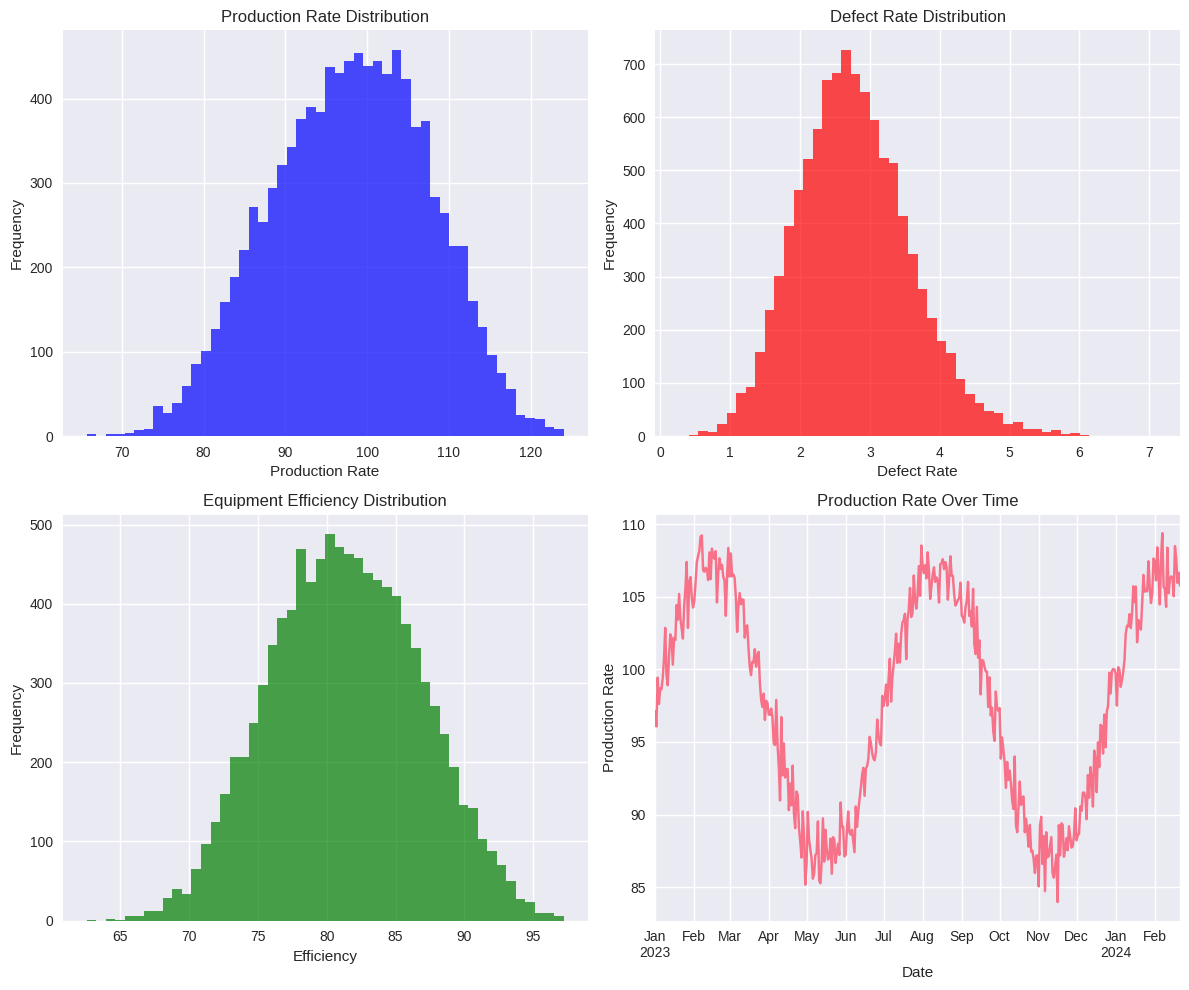

In [57]:
# Cell 12: Explore the generated data
print("Data Exploration")
print("=" * 40)

# Basic statistics
print("Basic Statistics:")
print(manufacturing_data.describe())

# Check for missing values
print(f"\nMissing values: {manufacturing_data.isnull().sum().sum()}")

# Plot KPI distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Production Rate distribution
axes[0, 0].hist(manufacturing_data['production_rate'], bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('Production Rate Distribution')
axes[0, 0].set_xlabel('Production Rate')
axes[0, 0].set_ylabel('Frequency')

# Defect Rate distribution
axes[0, 1].hist(manufacturing_data['defect_rate'], bins=50, alpha=0.7, color='red')
axes[0, 1].set_title('Defect Rate Distribution')
axes[0, 1].set_xlabel('Defect Rate')
axes[0, 1].set_ylabel('Frequency')

# Equipment Efficiency distribution
axes[1, 0].hist(manufacturing_data['equipment_efficiency'], bins=50, alpha=0.7, color='green')
axes[1, 0].set_title('Equipment Efficiency Distribution')
axes[1, 0].set_xlabel('Efficiency')
axes[1, 0].set_ylabel('Frequency')

# Time series of production rate
manufacturing_data.set_index('timestamp')['production_rate'].resample('D').mean().plot(ax=axes[1, 1])
axes[1, 1].set_title('Production Rate Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Production Rate')

plt.tight_layout()
plt.show()

In [58]:
# Cell 13: Split data and setup drift detection
print("Splitting data and setting up drift detection...")

# Split data into reference and current periods
split_date = manufacturing_data['timestamp'].quantile(0.7)
reference_data = manufacturing_data[manufacturing_data['timestamp'] <= split_date]
current_data = manufacturing_data[manufacturing_data['timestamp'] > split_date]

print(f"Reference period: {len(reference_data)} samples")
print(f"Current period: {len(current_data)} samples")
print(f"Split date: {split_date}")

# Setup drift detection
numerical_features = ['temperature', 'pressure', 'vibration', 'humidity',
                     'machine_speed', 'equipment_age_days']
monitor.setup_drift_detection(reference_data, numerical_features)

print(f"Drift detection setup for features: {numerical_features}")

Splitting data and setting up drift detection...
Reference period: 7000 samples
Current period: 3000 samples
Split date: 2023-10-19 15:18:00
Drift detection setup for features: ['temperature', 'pressure', 'vibration', 'humidity', 'machine_speed', 'equipment_age_days']


In [59]:
# Cell 14: Analyze feature drift
print("\nAnalyzing feature drift...")
feature_drift_results = monitor.detect_feature_drift(current_data, numerical_features)

print("Feature Drift Results:")
print("-" * 30)
for feature, result in feature_drift_results.items():
    status = "DRIFT DETECTED" if result['drift_detected'] else " No Drift"
    print(f"{feature}: {status}")
    print(f"  p-value: {result['p_value']:.6f}")
    print(f"  Drift magnitude: {result['drift_magnitude']:.4f}")
    print(f"  Reference mean: {result['reference_mean']:.2f}")
    print(f"  Current mean: {result['current_mean']:.2f}")
    print()


Analyzing feature drift...
Feature Drift Results:
------------------------------
temperature:  No Drift
  p-value: 0.533697
  Drift magnitude: 0.0010
  Reference mean: 74.97
  Current mean: 75.04

pressure:  No Drift
  p-value: 0.981661
  Drift magnitude: 0.0009
  Reference mean: 100.11
  Current mean: 100.20

vibration:  No Drift
  p-value: 0.530176
  Drift magnitude: 0.0051
  Reference mean: 2.50
  Current mean: 2.48

humidity:  No Drift
  p-value: 0.495489
  Drift magnitude: 0.0031
  Reference mean: 44.90
  Current mean: 45.04

machine_speed:  No Drift
  p-value: 0.719302
  Drift magnitude: 0.0008
  Reference mean: 1501.03
  Current mean: 1499.79

equipment_age_days:  No Drift
  p-value: 0.448763
  Drift magnitude: 0.0133
  Reference mean: 542.33
  Current mean: 549.55



In [60]:
# Cell 15: Analyze KPI drift
print("Analyzing KPI drift...")
kpi_drift_results = monitor.analyze_kpi_drift(
    reference_data[['production_rate', 'defect_rate', 'equipment_efficiency']],
    current_data[['production_rate', 'defect_rate', 'equipment_efficiency']]
)

print("KPI Drift Results:")
print("-" * 30)
for kpi, result in kpi_drift_results.items():
    print(f"{kpi}:")
    print(f"  Severity: {result['severity']}")
    print(f"  p-value: {result['p_value']:.6f}")
    print(f"  Drift magnitude: {result['drift_magnitude']:.4f}")
    print(f"  Reference mean: {result['reference_mean']:.2f}")
    print(f"  Current mean: {result['current_mean']:.2f}")
    print()

Analyzing KPI drift...
KPI Drift Results:
------------------------------
production_rate:
  Severity: NORMAL
  p-value: 0.000000
  Drift magnitude: 0.0250
  Reference mean: 98.72
  Current mean: 96.24

defect_rate:
  Severity: WARNING
  p-value: 0.000000
  Drift magnitude: 0.0383
  Reference mean: 2.75
  Current mean: 2.85

equipment_efficiency:
  Severity: NORMAL
  p-value: 0.000000
  Drift magnitude: 0.0164
  Reference mean: 81.78
  Current mean: 80.44



In [61]:
# Cell 16: Analyze bias in manufacturing data
print("Analyzing bias in manufacturing data...")
protected_attributes = ['operator_shift', 'material_quality']
bias_results = {}

for kpi in ['defect_rate', 'production_rate']:
    print(f"\nBias Analysis for {kpi}:")
    print("-" * 30)
    bias_results[kpi] = monitor.analyze_bias(manufacturing_data, protected_attributes, kpi)

    for attribute, result in bias_results[kpi].items():
        status = "BIAS DETECTED" if result['is_biased'] else "No Bias"
        print(f"{attribute}: {status}")
        print(f"  p-value: {result['p_value']:.6f}")
        print(f"  Max bias: {result['max_bias']:.4f}")
        print(f"  Group means: {result['group_means']}")
        print()

Analyzing bias in manufacturing data...

Bias Analysis for defect_rate:
------------------------------
operator_shift: BIAS DETECTED
  p-value: 0.000000
  Max bias: 0.1863
  Group means: {'Evening': 2.612963652239799, 'Morning': 2.6064805556655033, 'Night': 3.1247504651783733}

material_quality: No Bias
  p-value: 0.415537
  Max bias: 0.0085
  Group means: {'A': 2.7862994255992444, 'B': 2.7627337034608948, 'C': 2.7635082778053133}


Bias Analysis for production_rate:
------------------------------
operator_shift: No Bias
  p-value: 0.783698
  Max bias: 0.0016
  Group means: {'Evening': 97.88648579107497, 'Morning': 97.99010903347538, 'Night': 98.04712771448642}

material_quality: No Bias
  p-value: 0.216082
  Max bias: 0.0059
  Group means: {'A': 97.91911786136123, 'B': 97.92638741572134, 'C': 98.49310973633341}



In [62]:
# Cell 17: Train predictive model
print("Training predictive model for defect rate prediction...")

# Prepare features
feature_cols = ['temperature', 'pressure', 'vibration', 'machine_speed',
               'equipment_age_days', 'maintenance_count']
model_features = pd.get_dummies(
    manufacturing_data[feature_cols + ['operator_shift', 'material_quality']],
    columns=['operator_shift', 'material_quality']
)

print(f"Training features shape: {model_features.shape}")

# Train model
model_results = monitor.train_predictive_model(
    model_features, manufacturing_data['defect_rate']
)

print("Model Training Results:")
print("-" * 30)
print(f"Mean Absolute Error: {model_results['mae']:.4f}")
print(f"R² Score: {model_results['r2']:.4f}")

Training predictive model for defect rate prediction...
Training features shape: (10000, 12)
Model Training Results:
------------------------------
Mean Absolute Error: 0.3842
R² Score: 0.6252


 Generating comprehensive dashboard...


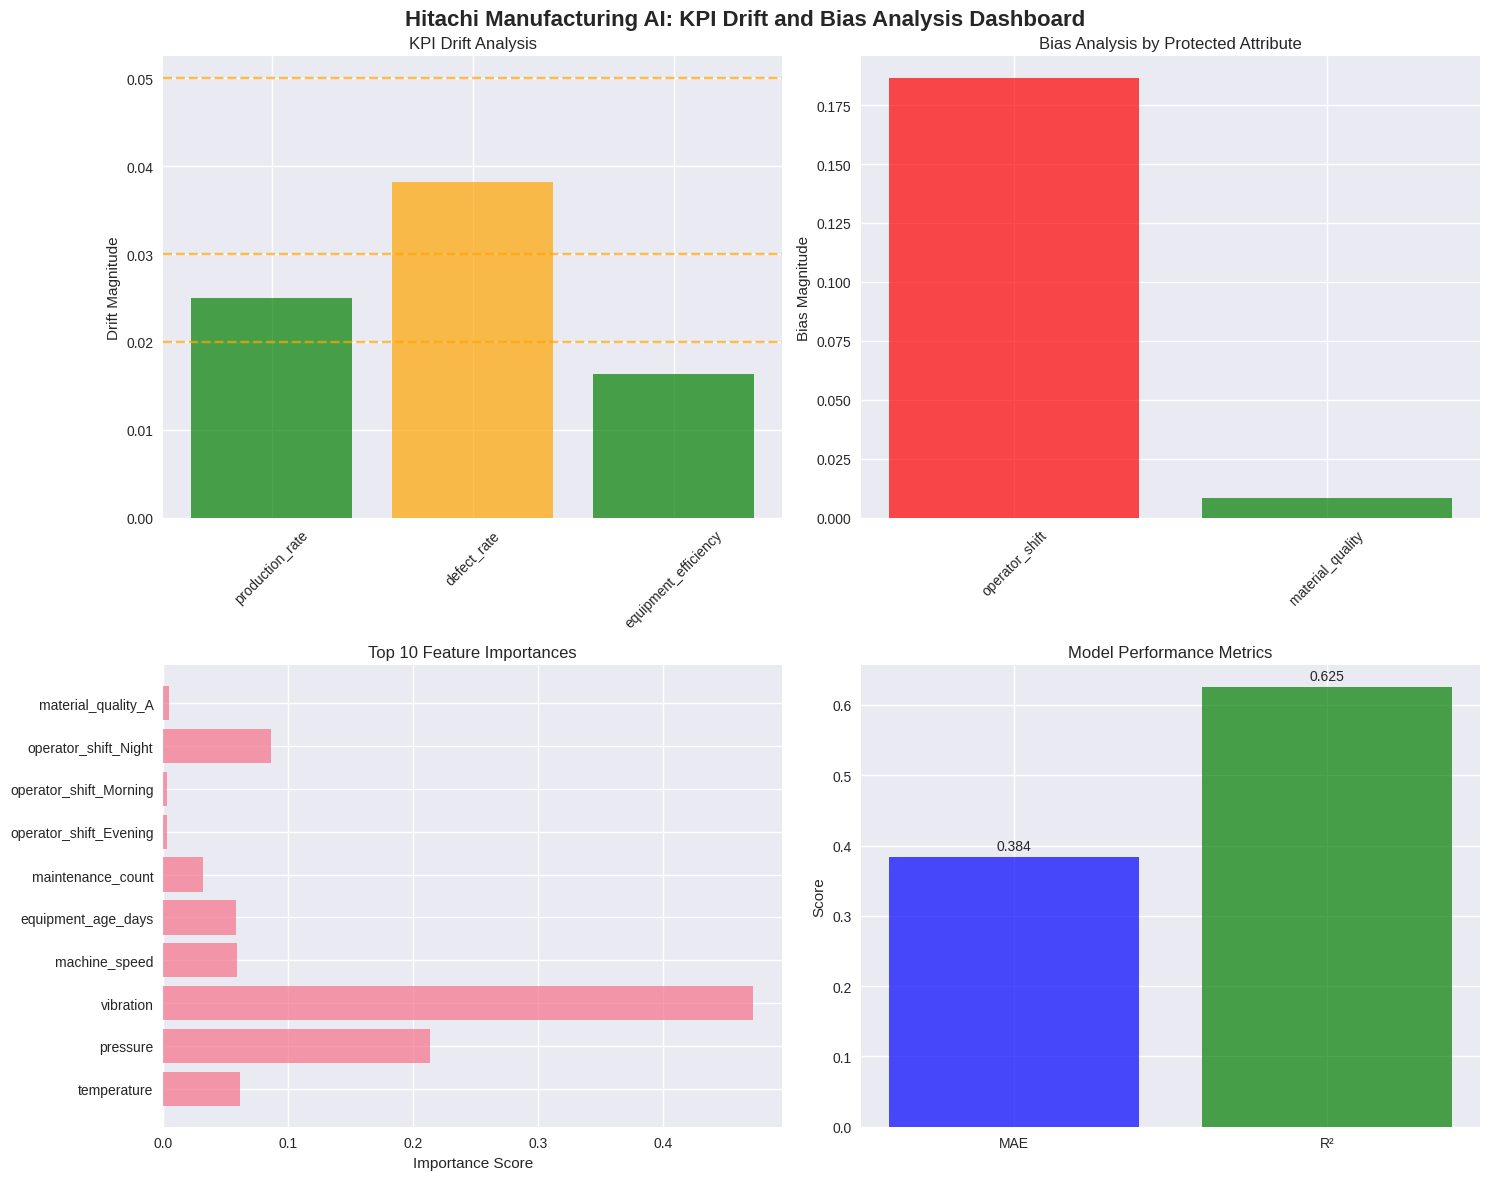

In [63]:
# Cell 18: Generate comprehensive dashboard
print(" Generating comprehensive dashboard...")
monitor.generate_dashboard(kpi_drift_results, bias_results['defect_rate'], model_results)

In [64]:
# Cell 19: Generate alert report
print("\nGenerating alert report.")
monitor.generate_alert_report(kpi_drift_results, bias_results['defect_rate'])


Generating alert report.
MANUFACTURING AI ALERT REPORT

CRITICAL ALERTS:
   • BIAS DETECTED: Significant bias found in operator_shift (p-value: 0.000000)

WARNING ALERTS:
   • WARNING: defect_rate shows warning-level drift (magnitude: 0.038)


In [65]:
# Cell 20: Print detailed results summary
print("\n" + "="*60)
print("DETAILED ANALYSIS RESULTS SUMMARY")
print("="*60)

print("\nKPI DRIFT RESULTS:")
for kpi, result in kpi_drift_results.items():
    print(f"  {kpi.upper()}:")
    print(f"    • Severity: {result['severity']}")
    print(f"    • Drift Magnitude: {result['drift_magnitude']:.4f}")
    print(f"    • Statistical Significance (p-value): {result['p_value']:.6f}")
    print(f"    • Reference Mean: {result['reference_mean']:.2f}")
    print(f"    • Current Mean: {result['current_mean']:.2f}")

print("\nBIAS ANALYSIS RESULTS:")
for kpi, biases in bias_results.items():
    print(f"  {kpi.upper()}:")
    for attribute, result in biases.items():
        bias_status = "PRESENT" if result['is_biased'] else "ABSENT"
        print(f"    • {attribute}: Bias {bias_status}")
        print(f"      - p-value: {result['p_value']:.6f}")
        print(f"      - Maximum Bias: {result['max_bias']:.4f}")

print("\nMODEL PERFORMANCE:")
print(f"  • Mean Absolute Error: {model_results['mae']:.4f}")
print(f"  • R² Score: {model_results['r2']:.4f}")

# Feature importance
print("\nTOP 5 FEATURE IMPORTANCES:")
feature_importance = sorted(
    model_results['feature_importance'].items(),
    key=lambda x: x[1],
    reverse=True
)[:5]

for feature, importance in feature_importance:
    print(f"  • {feature}: {importance:.4f}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


DETAILED ANALYSIS RESULTS SUMMARY

KPI DRIFT RESULTS:
  PRODUCTION_RATE:
    • Severity: NORMAL
    • Drift Magnitude: 0.0250
    • Statistical Significance (p-value): 0.000000
    • Reference Mean: 98.72
    • Current Mean: 96.24
  DEFECT_RATE:
    • Severity: WARNING
    • Drift Magnitude: 0.0383
    • Statistical Significance (p-value): 0.000000
    • Reference Mean: 2.75
    • Current Mean: 2.85
  EQUIPMENT_EFFICIENCY:
    • Severity: NORMAL
    • Drift Magnitude: 0.0164
    • Statistical Significance (p-value): 0.000000
    • Reference Mean: 81.78
    • Current Mean: 80.44

BIAS ANALYSIS RESULTS:
  DEFECT_RATE:
    • operator_shift: Bias PRESENT
      - p-value: 0.000000
      - Maximum Bias: 0.1863
    • material_quality: Bias ABSENT
      - p-value: 0.415537
      - Maximum Bias: 0.0085
  PRODUCTION_RATE:
    • operator_shift: Bias ABSENT
      - p-value: 0.783698
      - Maximum Bias: 0.0016
    • material_quality: Bias ABSENT
      - p-value: 0.216082
      - Maximum Bias: 0.

Correlation Analysis


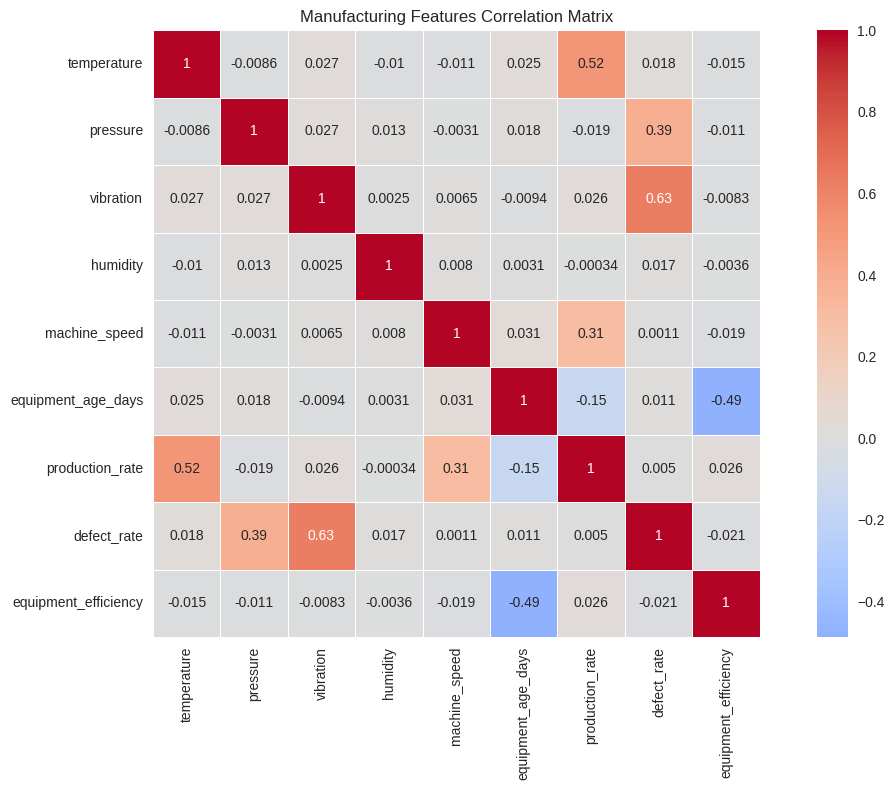


Strongest correlations with Defect Rate:
defect_rate             1.000000
vibration               0.629328
pressure                0.386752
equipment_efficiency    0.021418
temperature             0.018495
humidity                0.016653
Name: defect_rate, dtype: float64


In [66]:
# Cell 21: Additional correlation analysis
print("Correlation Analysis")
print("=" * 30)

# Calculate correlation matrix
correlation_matrix = manufacturing_data[numerical_features + ['production_rate', 'defect_rate', 'equipment_efficiency']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Manufacturing Features Correlation Matrix')
plt.tight_layout()
plt.show()

# Print strongest correlations with KPIs
print("\nStrongest correlations with Defect Rate:")
defect_correlations = correlation_matrix['defect_rate'].abs().sort_values(ascending=False)
print(defect_correlations.head(6))

Time-based Drift Analysis
Categorical Data Distribution Over Time:
----------------------------------------


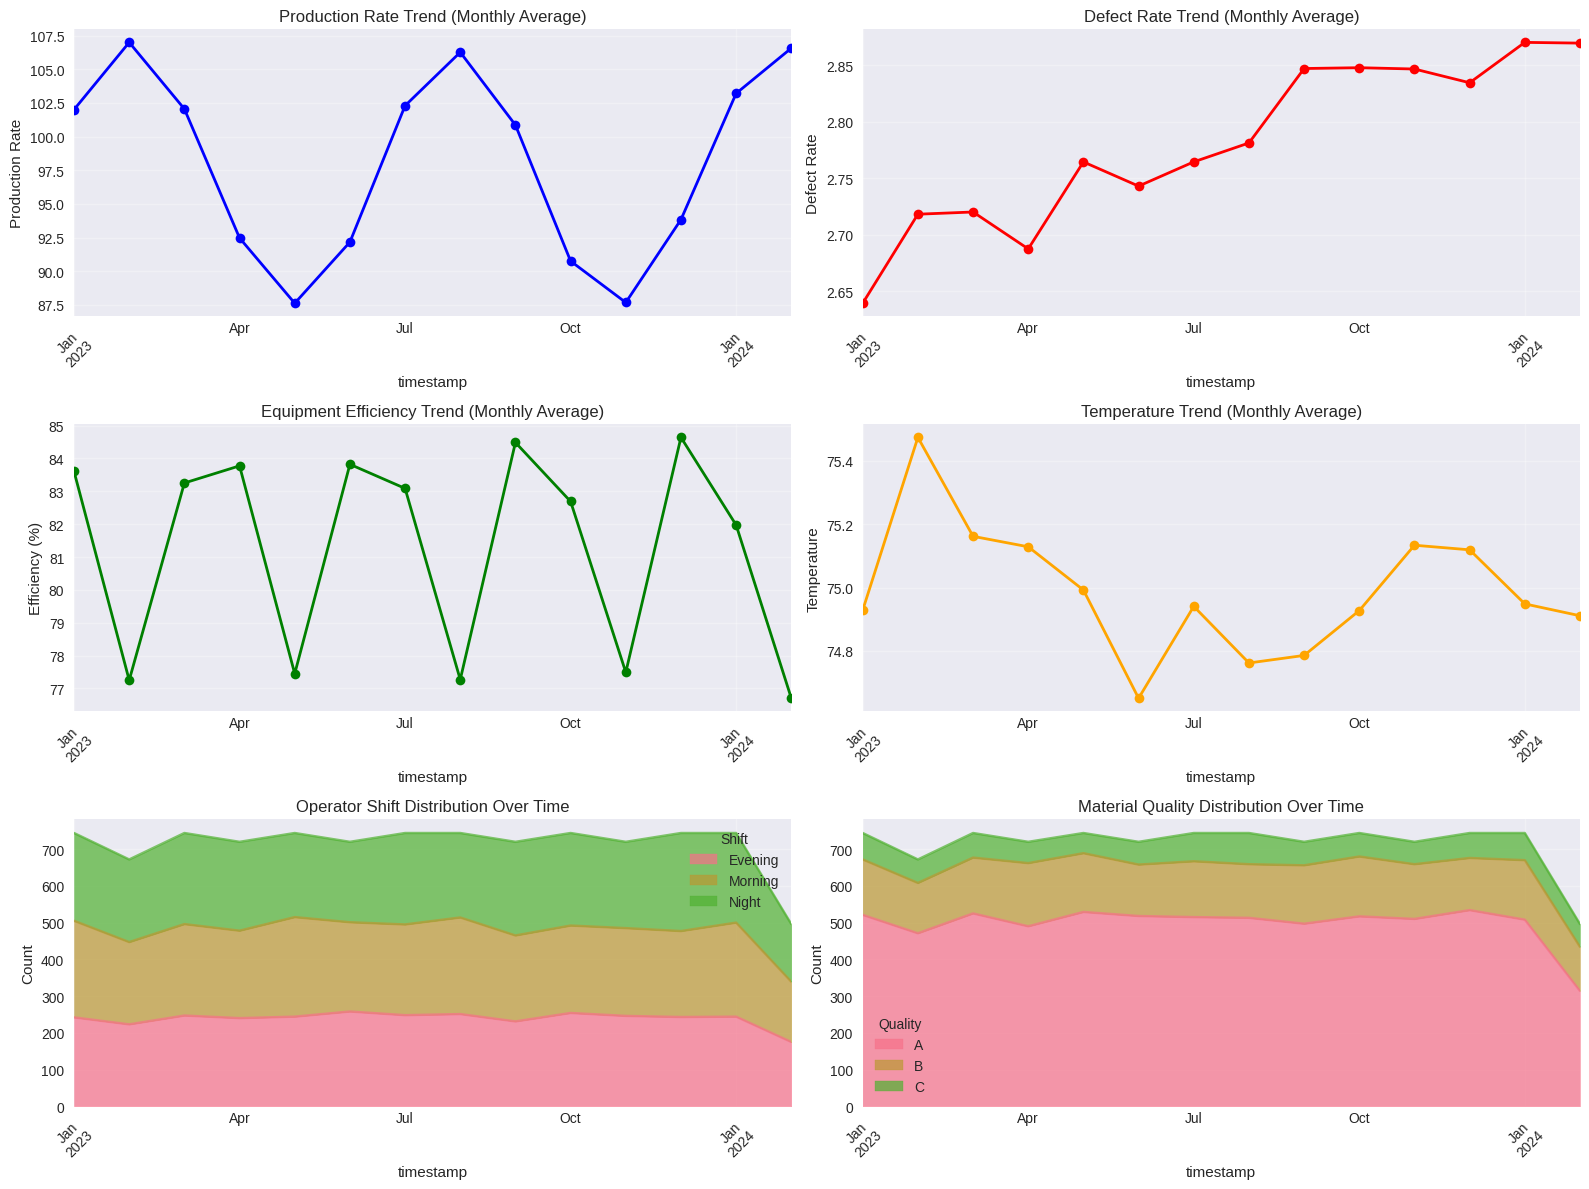


Monthly Trend Summary:

KPI Changes from First to Last Month:
          production_rate: 102.01 → 106.57 (+4.56 ↑ +4.5%)
              defect_rate: 2.64 → 2.87 (+0.23 ↑ +8.7%)
     equipment_efficiency: 83.61 → 76.70 (-6.91 ↓ -8.3%)

Categorical Distribution Changes:
Operator Shift (first vs last month):
  First month: {'Evening': np.int64(242), 'Morning': np.int64(263), 'Night': np.int64(239)}
  Last month:  {'Evening': np.int64(175), 'Morning': np.int64(164), 'Night': np.int64(157)}

Material Quality (first vs last month):
  First month: {'A': np.int64(521), 'B': np.int64(151), 'C': np.int64(72)}
  Last month:  {'A': np.int64(314), 'B': np.int64(120), 'C': np.int64(62)}


In [67]:
# Cell 22: Fixed Time-based Drift Analysis
print("Time-based Drift Analysis")
print("=" * 30)

# Select only numerical columns for resampling and mean calculation
numerical_columns = ['temperature', 'pressure', 'vibration', 'humidity', 'machine_speed',
                    'equipment_age_days', 'maintenance_count', 'production_rate',
                    'defect_rate', 'equipment_efficiency']

# Resample data by month for trend analysis (only numerical columns)
monthly_data_numerical = manufacturing_data.set_index('timestamp')[numerical_columns].resample('M').mean()

# For categorical data, let's do value counts instead
categorical_columns = ['operator_shift', 'material_quality', 'quality_rating']

# Create separate analysis for categorical data
print("Categorical Data Distribution Over Time:")
print("-" * 40)

# Analyze operator shift distribution over time
operator_monthly = manufacturing_data.set_index('timestamp').groupby(
    [pd.Grouper(freq='M'), 'operator_shift']
).size().unstack(fill_value=0)

# Analyze material quality distribution over time
material_monthly = manufacturing_data.set_index('timestamp').groupby(
    [pd.Grouper(freq='M'), 'material_quality']
).size().unstack(fill_value=0)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. KPI Trends (Numerical Data)
monthly_data_numerical['production_rate'].plot(ax=axes[0, 0], color='blue', linewidth=2, marker='o')
axes[0, 0].set_title('Production Rate Trend (Monthly Average)')
axes[0, 0].set_ylabel('Production Rate')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

monthly_data_numerical['defect_rate'].plot(ax=axes[0, 1], color='red', linewidth=2, marker='o')
axes[0, 1].set_title('Defect Rate Trend (Monthly Average)')
axes[0, 1].set_ylabel('Defect Rate')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

monthly_data_numerical['equipment_efficiency'].plot(ax=axes[1, 0], color='green', linewidth=2, marker='o')
axes[1, 0].set_title('Equipment Efficiency Trend (Monthly Average)')
axes[1, 0].set_ylabel('Efficiency (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 2. Process Parameter Trends
monthly_data_numerical['temperature'].plot(ax=axes[1, 1], color='orange', linewidth=2, marker='o')
axes[1, 1].set_title('Temperature Trend (Monthly Average)')
axes[1, 1].set_ylabel('Temperature')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# 3. Categorical Data Trends - Operator Shift
operator_monthly.plot(kind='area', ax=axes[2, 0], alpha=0.7)
axes[2, 0].set_title('Operator Shift Distribution Over Time')
axes[2, 0].set_ylabel('Count')
axes[2, 0].legend(title='Shift')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].tick_params(axis='x', rotation=45)

# 4. Categorical Data Trends - Material Quality
material_monthly.plot(kind='area', ax=axes[2, 1], alpha=0.7)
axes[2, 1].set_title('Material Quality Distribution Over Time')
axes[2, 1].set_ylabel('Count')
axes[2, 1].legend(title='Quality')
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMonthly Trend Summary:")
print("=" * 40)

print("\nKPI Changes from First to Last Month:")
first_month = monthly_data_numerical.iloc[0]
last_month = monthly_data_numerical.iloc[-1]

for kpi in ['production_rate', 'defect_rate', 'equipment_efficiency']:
    change = last_month[kpi] - first_month[kpi]
    change_pct = (change / first_month[kpi]) * 100
    direction = "↑" if change > 0 else "↓"
    print(f"{kpi:>25}: {first_month[kpi]:.2f} → {last_month[kpi]:.2f} "
          f"({change:+.2f} {direction} {change_pct:+.1f}%)")

print("\nCategorical Distribution Changes:")
print("Operator Shift (first vs last month):")
print(f"  First month: {dict(operator_monthly.iloc[0])}")
print(f"  Last month:  {dict(operator_monthly.iloc[-1])}")

print("\nMaterial Quality (first vs last month):")
print(f"  First month: {dict(material_monthly.iloc[0])}")
print(f"  Last month:  {dict(material_monthly.iloc[-1])}")



Time-based Drift Analysis
Numerical columns for analysis: ['temperature', 'pressure', 'vibration', 'humidity', 'machine_speed', 'equipment_age_days', 'maintenance_count', 'production_rate', 'defect_rate', 'equipment_efficiency']


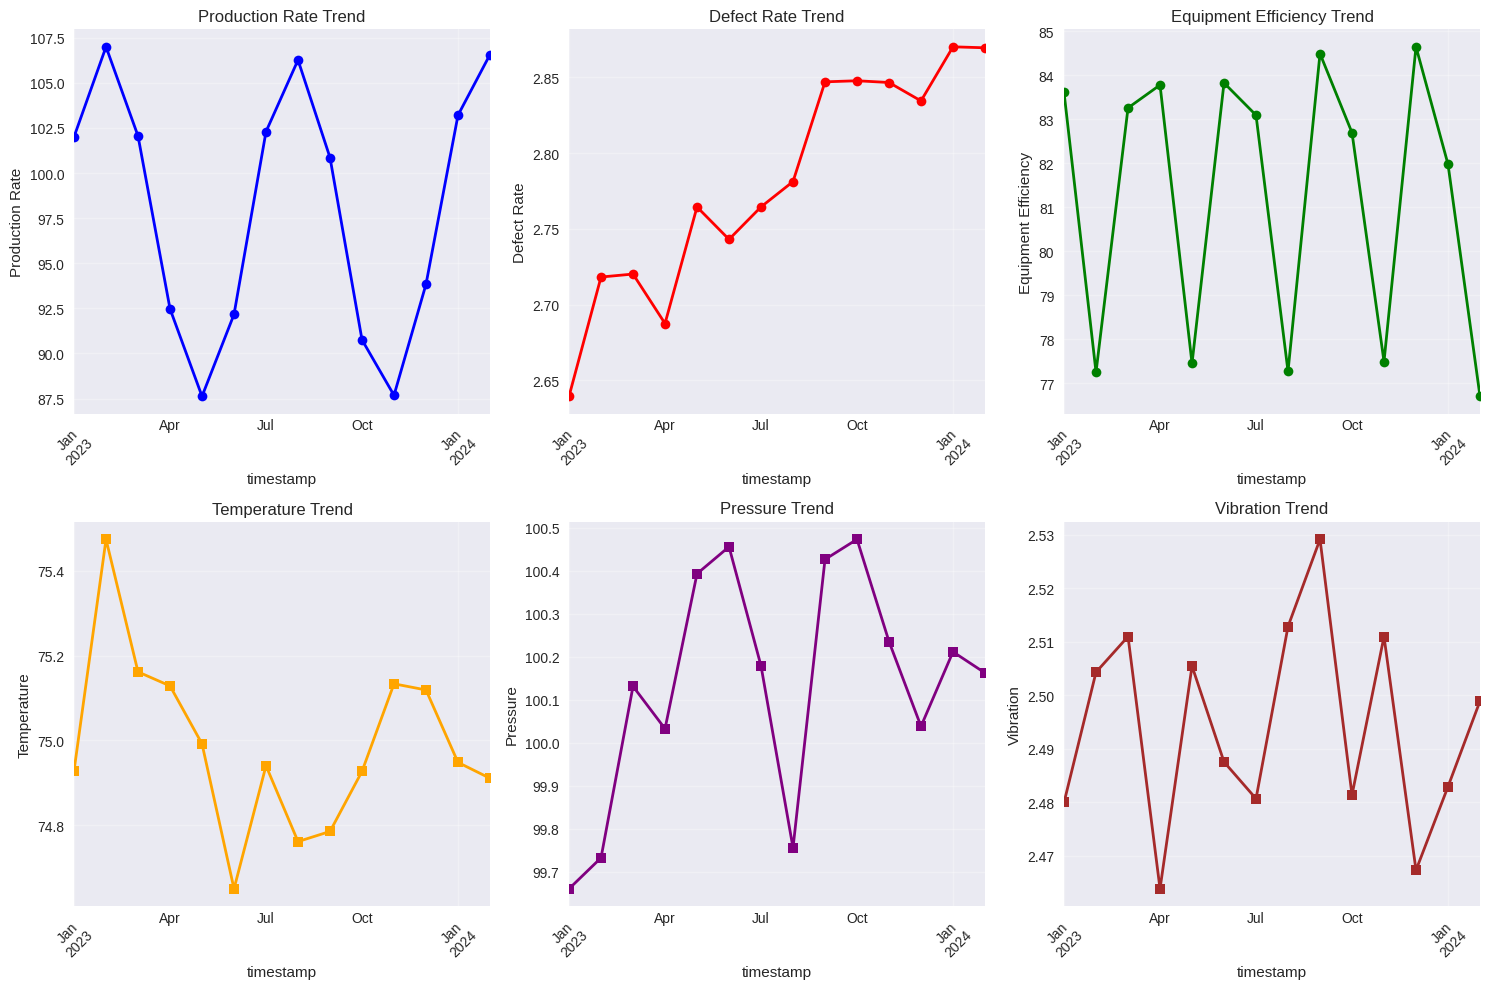


📈 Drift Metrics (First vs Last Month):
---------------------------------------------
     production_rate:  102.01 →  106.57 (Δ=+4.56, +4.5%) LOW DRIFT
         defect_rate:    2.64 →    2.87 (Δ=+0.23, +8.7%) MODERATE DRIFT
equipment_efficiency:   83.61 →   76.70 (Δ=-6.91, -8.3%) MODERATE DRIFT


In [69]:
# Cell 22: Simplified Time-based Drift Analysis
print("Time-based Drift Analysis")
print("=" * 40)

# Create a copy and ensure we only use numerical data
analysis_data = manufacturing_data.copy()

# Convert timestamp to datetime index
analysis_data = analysis_data.set_index('timestamp')

# Select only numerical columns for resampling
numerical_cols = analysis_data.select_dtypes(include=[np.number]).columns

print(f"Numerical columns for analysis: {list(numerical_cols)}")

# Resample numerical data monthly
monthly_numerical = analysis_data[numerical_cols].resample('M').mean()

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot key KPIs
key_kpis = ['production_rate', 'defect_rate', 'equipment_efficiency']
colors = ['blue', 'red', 'green']

for i, kpi in enumerate(key_kpis):
    if kpi in monthly_numerical.columns:
        monthly_numerical[kpi].plot(ax=axes[0, i], color=colors[i], linewidth=2, marker='o')
        axes[0, i].set_title(f'{kpi.replace("_", " ").title()} Trend')
        axes[0, i].set_ylabel(kpi.replace('_', ' ').title())
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].tick_params(axis='x', rotation=45)

# Plot key process parameters
key_params = ['temperature', 'pressure', 'vibration']
param_colors = ['orange', 'purple', 'brown']

for i, param in enumerate(key_params):
    if param in monthly_numerical.columns:
        monthly_numerical[param].plot(ax=axes[1, i], color=param_colors[i], linewidth=2, marker='s')
        axes[1, i].set_title(f'{param.title()} Trend')
        axes[1, i].set_ylabel(param.title())
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate and display drift metrics
print("\n📈 Drift Metrics (First vs Last Month):")
print("-" * 45)

for kpi in key_kpis:
    if kpi in monthly_numerical.columns:
        first_val = monthly_numerical[kpi].iloc[0]
        last_val = monthly_numerical[kpi].iloc[-1]
        absolute_drift = last_val - first_val
        relative_drift = (absolute_drift / first_val) * 100

        # Determine drift category
        if abs(relative_drift) > 10:
            category = "HIGH DRIFT"
        elif abs(relative_drift) > 5:
            category = "MODERATE DRIFT"
        else:
            category = "LOW DRIFT"

        print(f"{kpi:>20}: {first_val:7.2f} → {last_val:7.2f} "
              f"(Δ={absolute_drift:+.2f}, {relative_drift:+.1f}%) {category}")

Enhanced Time-based Drift Analysis with Statistical Tests

Statistical Trend Analysis:
-----------------------------------
     production_rate: ↑ Increasing (slope: 0.2023, p-value: 0.9430) (not significant)
         defect_rate: ↑ Increasing (slope: 0.0467, p-value: 0.0009) **
equipment_efficiency: ↓ Decreasing (slope: -0.3269, p-value: 0.2196) (not significant)


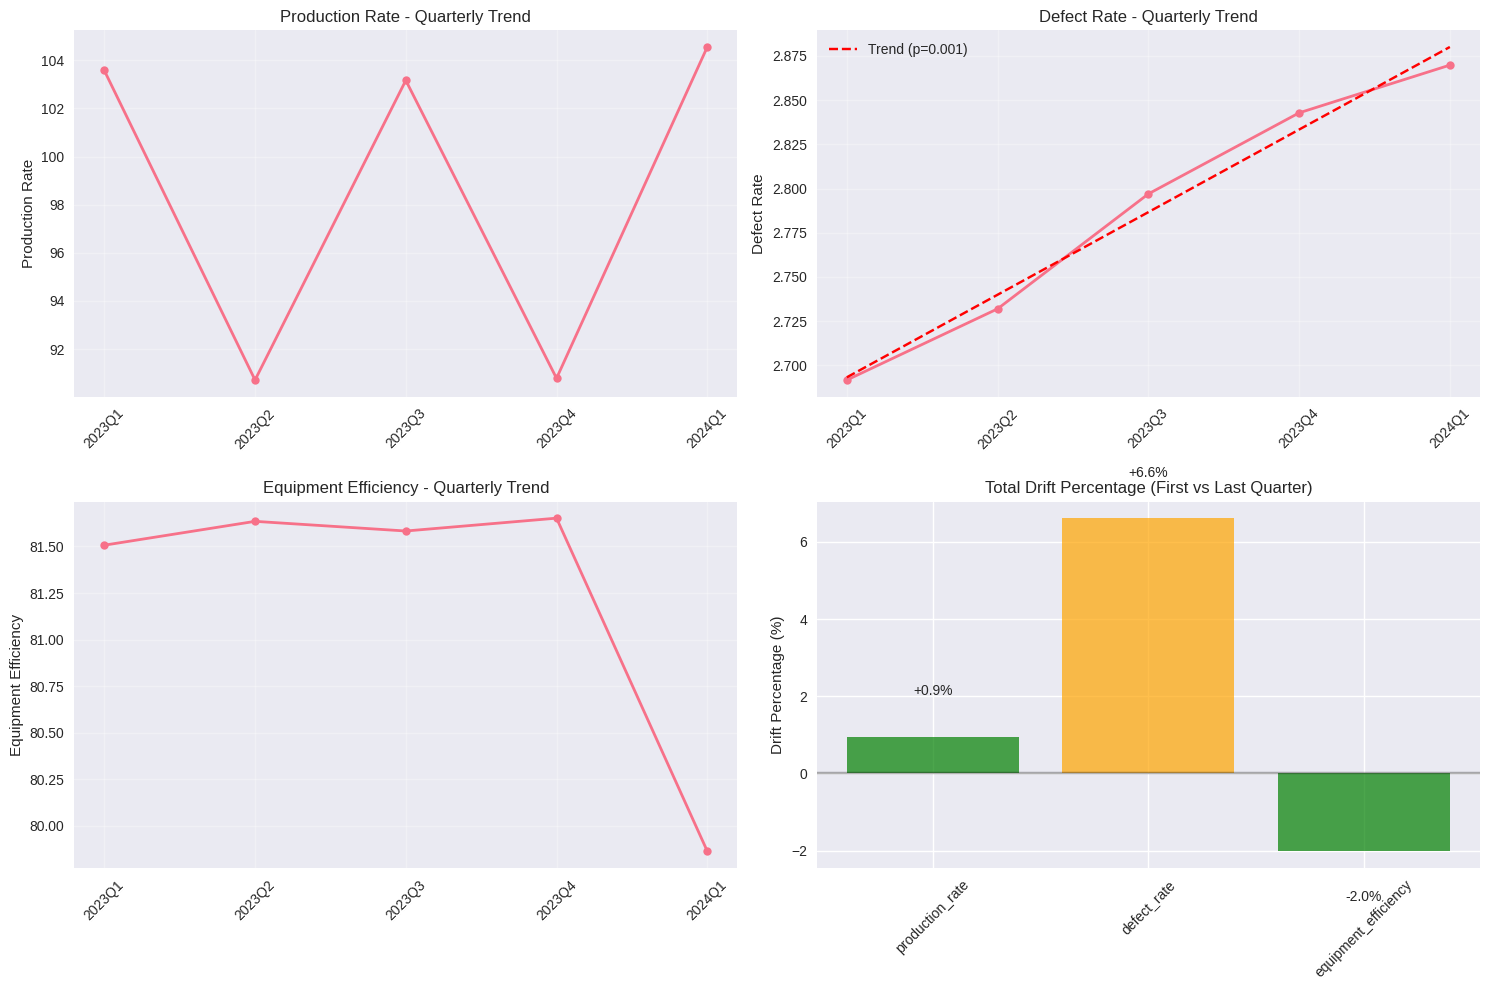


 Key Insights:
• Production Rate shows no statistically significant trend
• Defect Rate shows statistically significant ↑ Increasing trend
• Equipment Efficiency shows no statistically significant trend


In [71]:
# Cell 22: Enhanced Time-based Drift Analysis with Statistical Tests
print("Enhanced Time-based Drift Analysis with Statistical Tests")
print("=" * 55)

# Prepare data - split into quarters for trend analysis
manufacturing_data['quarter'] = manufacturing_data['timestamp'].dt.to_period('Q')
quarterly_data = manufacturing_data.groupby('quarter').agg({
    'production_rate': 'mean',
    'defect_rate': 'mean',
    'equipment_efficiency': 'mean',
    'temperature': 'mean',
    'pressure': 'mean',
    'vibration': 'mean'
}).reset_index()

quarterly_data['quarter_str'] = quarterly_data['quarter'].astype(str)

# Statistical trend analysis
from scipy.stats import linregress

print("\nStatistical Trend Analysis:")
print("-" * 35)

trend_results = {}
for kpi in ['production_rate', 'defect_rate', 'equipment_efficiency']:
    x = np.arange(len(quarterly_data))
    y = quarterly_data[kpi].values

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    trend = "↑ Increasing" if slope > 0 else "↓ Decreasing"
    significance = "**" if p_value < 0.05 else "(not significant)"

    trend_results[kpi] = {
        'slope': slope,
        'p_value': p_value,
        'r_squared': r_value**2,
        'trend': trend
    }

    print(f"{kpi:>20}: {trend} (slope: {slope:.4f}, p-value: {p_value:.4f}) {significance}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. KPI Trends with regression lines
for i, kpi in enumerate(['production_rate', 'defect_rate', 'equipment_efficiency']):
    row, col = i // 2, i % 2
    if row < 2:  # Ensure we don't exceed subplot bounds
        x = np.arange(len(quarterly_data))
        y = quarterly_data[kpi].values

        axes[row, col].plot(quarterly_data['quarter_str'], y, 'o-', linewidth=2, markersize=6)
        axes[row, col].set_title(f'{kpi.replace("_", " ").title()} - Quarterly Trend')
        axes[row, col].set_ylabel(kpi.replace('_', ' ').title())
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].grid(True, alpha=0.3)

        # Add trend line if significant
        if trend_results[kpi]['p_value'] < 0.05:
            slope = trend_results[kpi]['slope']
            intercept = y.mean() - slope * x.mean()
            trend_line = slope * x + intercept
            axes[row, col].plot(quarterly_data['quarter_str'], trend_line, 'r--',
                              label=f"Trend (p={trend_results[kpi]['p_value']:.3f})")
            axes[row, col].legend()

# 4. Overall drift summary
drift_summary = []
for kpi in ['production_rate', 'defect_rate', 'equipment_efficiency']:
    first_q = quarterly_data[kpi].iloc[0]
    last_q = quarterly_data[kpi].iloc[-1]
    drift_pct = ((last_q - first_q) / first_q) * 100
    drift_summary.append((kpi, first_q, last_q, drift_pct))

# Create bar chart for drift summary
kpis = [x[0] for x in drift_summary]
drifts = [x[3] for x in drift_summary]
colors = ['green' if abs(d) < 5 else 'orange' if abs(d) < 10 else 'red' for d in drifts]

axes[1, 1].bar(kpis, drifts, color=colors, alpha=0.7)
axes[1, 1].set_title('Total Drift Percentage (First vs Last Quarter)')
axes[1, 1].set_ylabel('Drift Percentage (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(drifts):
    axes[1, 1].text(i, v + (1 if v > 0 else -1), f'{v:+.1f}%',
                   ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()

print("\n Key Insights:")
print("=" * 35)
for kpi, result in trend_results.items():
    if result['p_value'] < 0.05:
        print(f"• {kpi.replace('_', ' ').title()} shows statistically significant {result['trend']} trend")
    else:
        print(f"• {kpi.replace('_', ' ').title()} shows no statistically significant trend")
